In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn.datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.nn.functional import normalize
from torch.nn import Module
from typing import Any, Optional, TypeVar
import math
import copy

In [2]:
np.random.seed(0)
torch.manual_seed(0)

### Setup

In [3]:
# Define visulization macors

plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

### The two moon dataset

In [4]:
def make_training_data(sample_size = 500):

    # Create two moon Training dataset
    train_examples, train_labels = sklearn.datasets.make_moons(n_samples=2 * sample_size, noise=0.1)

    # Adjust data position slightly
    train_examples[train_labels == 0] += [-0.1, 0.2]
    train_examples[train_labels == 1] += [0.1, -0.2]

    return torch.tensor(train_examples, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.float32)

def make_testing_data(x_range = DEFAULT_X_RANGE, y_range = DEFAULT_Y_RANGE, n_grid = DEFAULT_N_GRID):

    # Create a mesh grid in 2D space
    # Testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)

    return torch.stack([torch.tensor(xv.flatten(), dtype=torch.float32), torch.tensor(yv.flatten(), dtype=torch.float32)], axis=-1)

def make_ood_data(sample_size = 500, means = (2.5, -1.75), vars = (0.01, 0.01)):
    return torch.tensor(np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size), dtype=torch.float32)

In [5]:
train_examples, train_labels = make_training_data(sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

### Auxiliary functions
- Spectral Normalization
- Mean Field Method

In [6]:
class SpectralNorm:
    # Invariant before and after each forward call:
    #   u = normalize(W @ v)
    # NB: At initialization, this invariant is not enforced

    _version: int = 1
    # At version 1:
    #   made  `W` not a buffer,
    #   added `v` as a buffer, and
    #   made eval mode use `W = u @ W_orig @ v` rather than the stored `W`.
    name: str
    dim: int
    n_power_iterations: int
    eps: float
    norm_bound: float

    def __init__(self, name: str = 'weight', n_power_iterations: int = 1, dim: int = 0, eps: float = 1e-12,
                 norm_bound: float = 0.95) -> None:
        self.name = name
        self.dim = dim
        if n_power_iterations <= 0:
            raise ValueError('Expected n_power_iterations to be positive, but '
                             'got n_power_iterations={}'.format(n_power_iterations))
        self.n_power_iterations = n_power_iterations
        self.eps = eps
        self.norm_bound = norm_bound

    def reshape_weight_to_matrix(self, weight: torch.Tensor) -> torch.Tensor:
        weight_mat = weight
        if self.dim != 0:
            # permute dim to front
            weight_mat = weight_mat.permute(self.dim,
                                            *[d for d in range(weight_mat.dim()) if d != self.dim])
        height = weight_mat.size(0)
        return weight_mat.reshape(height, -1)

    def compute_weight(self, module: Module, do_power_iteration: bool) -> torch.Tensor:
        # NB: If `do_power_iteration` is set, the `u` and `v` vectors are
        #     updated in power iteration **in-place**. This is very important
        #     because in `DataParallel` forward, the vectors (being buffers) are
        #     broadcast from the parallelized module to each module replica,
        #     which is a new module object created on the fly. And each replica
        #     runs its own spectral norm power iteration. So simply assigning
        #     the updated vectors to the module this function runs on will cause
        #     the update to be lost forever. And the next time the parallelized
        #     module is replicated, the same randomly initialized vectors are
        #     broadcast and used!
        #
        #     Therefore, to make the change propagate back, we rely on two
        #     important behaviors (also enforced via tests):
        #       1. `DataParallel` doesn't clone storage if the broadcast tensor
        #          is already on correct device; and it makes sure that the
        #          parallelized module is already on `device[0]`.
        #       2. If the out tensor in `out=` kwarg has correct shape, it will
        #          just fill in the values.
        #     Therefore, since the same power iteration is performed on all
        #     devices, simply updating the tensors in-place will make sure that
        #     the module replica on `device[0]` will update the _u vector on the
        #     parallized module (by shared storage).
        #
        #    However, after we update `u` and `v` in-place, we need to **clone**
        #    them before using them to normalize the weight. This is to support
        #    backproping through two forward passes, e.g., the common pattern in
        #    GAN training: loss = D(real) - D(fake). Otherwise, engine will
        #    complain that variables needed to do backward for the first forward
        #    (i.e., the `u` and `v` vectors) are changed in the second forward.
        weight = getattr(module, self.name + '_orig')
        u = getattr(module, self.name + '_u')
        v = getattr(module, self.name + '_v')
        weight_mat = self.reshape_weight_to_matrix(weight)

        if do_power_iteration:
            with torch.no_grad():
                for _ in range(self.n_power_iterations):
                    # Spectral norm of weight equals to `u^T W v`, where `u` and `v`
                    # are the first left and right singular vectors.
                    # This power iteration produces approximations of `u` and `v`.
                    v = normalize(torch.mv(weight_mat.t(), u), dim=0, eps=self.eps, out=v)
                    u = normalize(torch.mv(weight_mat, v), dim=0, eps=self.eps, out=u)
                if self.n_power_iterations > 0:
                    # See above on why we need to clone
                    u = u.clone(memory_format=torch.contiguous_format)
                    v = v.clone(memory_format=torch.contiguous_format)

        sigma = torch.dot(u, torch.mv(weight_mat, v))

        # To make the Lipschitz constant of the weight matrix bounded by the pre-defined norm_bound
        # https://github.com/google/edward2/blob/main/edward2/tensorflow/layers/normalization.py#L388
        w_norm = torch.where(self.norm_bound < sigma, (self.norm_bound / sigma) * weight, weight)

        # weight = weight / sigma
        return w_norm

    def remove(self, module: Module) -> None:
        with torch.no_grad():
            weight = self.compute_weight(module, do_power_iteration=False)
        delattr(module, self.name)
        delattr(module, self.name + '_u')
        delattr(module, self.name + '_v')
        delattr(module, self.name + '_orig')
        module.register_parameter(self.name, torch.nn.Parameter(weight.detach()))

    def __call__(self, module: Module, inputs: Any) -> None:
        setattr(module, self.name, self.compute_weight(module, do_power_iteration=module.training))

    def _solve_v_and_rescale(self, weight_mat, u, target_sigma):
        # Tries to returns a vector `v` s.t. `u = normalize(W @ v)`
        # (the invariant at top of this class) and `u @ W @ v = sigma`.
        # This uses pinverse in case W^T W is not invertible.
        v = torch.linalg.multi_dot([weight_mat.t().mm(weight_mat).pinverse(), weight_mat.t(), u.unsqueeze(1)]).squeeze(
            1)
        return v.mul_(target_sigma / torch.dot(u, torch.mv(weight_mat, v)))

    @staticmethod
    def apply(module: Module, name: str, n_power_iterations: int, dim: int, eps: float, norm_bound: float) -> 'SpectralNorm':
        for k, hook in module._forward_pre_hooks.items():
            if isinstance(hook, SpectralNorm) and hook.name == name:
                raise RuntimeError("Cannot register two spectral_norm hooks on "
                                   "the same parameter {}".format(name))

        fn = SpectralNorm(name, n_power_iterations, dim, eps, norm_bound)
        weight = module._parameters[name]
        if weight is None:
            raise ValueError(f'`SpectralNorm` cannot be applied as parameter `{name}` is None')
        if isinstance(weight, torch.nn.parameter.UninitializedParameter):
            raise ValueError(
                'The module passed to `SpectralNorm` can\'t have uninitialized parameters. '
                'Make sure to run the dummy forward before applying spectral normalization')

        with torch.no_grad():
            weight_mat = fn.reshape_weight_to_matrix(weight)

            h, w = weight_mat.size()
            # randomly initialize `u` and `v`
            u = normalize(weight.new_empty(h).normal_(0, 1), dim=0, eps=fn.eps)
            v = normalize(weight.new_empty(w).normal_(0, 1), dim=0, eps=fn.eps)

        delattr(module, fn.name)
        module.register_parameter(fn.name + "_orig", weight)
        # We still need to assign weight back as fn.name because all sorts of
        # things may assume that it exists, e.g., when initializing weights.
        # However, we can't directly assign as it could be an nn.Parameter and
        # gets added as a parameter. Instead, we register weight.data as a plain
        # attribute.
        setattr(module, fn.name, weight.data)
        module.register_buffer(fn.name + "_u", u)
        module.register_buffer(fn.name + "_v", v)

        module.register_forward_pre_hook(fn)
        module._register_state_dict_hook(SpectralNormStateDictHook(fn))
        module._register_load_state_dict_pre_hook(SpectralNormLoadStateDictPreHook(fn))
        return fn


# This is a top level class because Py2 pickle doesn't like inner class nor an
# instancemethod.
class SpectralNormLoadStateDictPreHook:
    # See docstring of SpectralNorm._version on the changes to spectral_norm.
    def __init__(self, fn) -> None:
        self.fn = fn

    # For state_dict with version None, (assuming that it has gone through at
    # least one training forward), we have
    #
    #    u = normalize(W_orig @ v)
    #    W = W_orig / sigma, where sigma = u @ W_orig @ v
    #
    # To compute `v`, we solve `W_orig @ x = u`, and let
    #    v = x / (u @ W_orig @ x) * (W / W_orig).
    def __call__(self, state_dict, prefix, local_metadata, strict,
                 missing_keys, unexpected_keys, error_msgs) -> None:
        fn = self.fn
        version = local_metadata.get('spectral_norm', {}).get(fn.name + '.version', None)
        if version is None or version < 1:
            weight_key = prefix + fn.name
            if version is None and all(weight_key + s in state_dict for s in ('_orig', '_u', '_v')) and \
                    weight_key not in state_dict:
                # Detect if it is the updated state dict and just missing metadata.
                # This could happen if the users are crafting a state dict themselves,
                # so we just pretend that this is the newest.
                return
            has_missing_keys = False
            for suffix in ('_orig', '', '_u'):
                key = weight_key + suffix
                if key not in state_dict:
                    has_missing_keys = True
                    if strict:
                        missing_keys.append(key)
            if has_missing_keys:
                return
            with torch.no_grad():
                weight_orig = state_dict[weight_key + '_orig']
                weight = state_dict.pop(weight_key)
                sigma = (weight_orig / weight).mean()
                weight_mat = fn.reshape_weight_to_matrix(weight_orig)
                u = state_dict[weight_key + '_u']
                v = fn._solve_v_and_rescale(weight_mat, u, sigma)
                state_dict[weight_key + '_v'] = v


# This is a top level class because Py2 pickle doesn't like inner class nor an
# instancemethod.
class SpectralNormStateDictHook:
    # See docstring of SpectralNorm._version on the changes to spectral_norm.
    def __init__(self, fn) -> None:
        self.fn = fn

    def __call__(self, module, state_dict, prefix, local_metadata) -> None:
        if 'spectral_norm' not in local_metadata:
            local_metadata['spectral_norm'] = {}
        key = self.fn.name + '.version'
        if key in local_metadata['spectral_norm']:
            raise RuntimeError("Unexpected key in metadata['spectral_norm']: {}".format(key))
        local_metadata['spectral_norm'][key] = self.fn._version


T_module = TypeVar('T_module', bound=Module)


def spectral_norm(module: T_module,
                  name: str = 'weight',
                  n_power_iterations: int = 1,
                  eps: float = 1e-12,
                  norm_bound: float = 0.95,
                  dim: Optional[int] = None,) -> T_module:
    r"""Applies spectral normalization to a parameter in the given module.
    .. math::
        \mathbf{W}_{SN} = \dfrac{\mathbf{W}}{\sigma(\mathbf{W})},
        \sigma(\mathbf{W}) = \max_{\mathbf{h}: \mathbf{h} \ne 0} \dfrac{\|\mathbf{W} \mathbf{h}\|_2}{\|\mathbf{h}\|_2}
    Spectral normalization stabilizes the training of discriminators (critics)
    in Generative Adversarial Networks (GANs) by rescaling the weight tensor
    with spectral norm :math:`\sigma` of the weight matrix calculated using
    power iteration method. If the dimension of the weight tensor is greater
    than 2, it is reshaped to 2D in power iteration method to get spectral
    norm. This is implemented via a hook that calculates spectral norm and
    rescales weight before every :meth:`~Module.forward` call.
    See `Spectral Normalization for Generative Adversarial Networks`_ .
    .. _`Spectral Normalization for Generative Adversarial Networks`: https://arxiv.org/abs/1802.05957
    Args:
        module (nn.Module): containing module
        name (str, optional): name of weight parameter
        n_power_iterations (int, optional): number of power iterations to
            calculate spectral norm
        eps (float, optional): epsilon for numerical stability in
            calculating norms
        dim (int, optional): dimension corresponding to number of outputs,
            the default is ``0``, except for modules that are instances of
            ConvTranspose{1,2,3}d, when it is ``1``
    Returns:
        The original module with the spectral norm hook
    .. note::
        This function has been reimplemented as
        :func:`torch.nn.utils.parametrizations.spectral_norm` using the new
        parametrization functionality in
        :func:`torch.nn.utils.parametrize.register_parametrization`. Please use
        the newer version. This function will be deprecated in a future version
        of PyTorch.
    Example::
        >>> m = spectral_norm(nn.Linear(20, 40))
        >>> m
        Linear(in_features=20, out_features=40, bias=True)
        >>> m.weight_u.size()
        torch.Size([40])
    """
    if dim is None:
        if isinstance(module, (torch.nn.ConvTranspose1d,
                               torch.nn.ConvTranspose2d,
                               torch.nn.ConvTranspose3d)):
            dim = 1
        else:
            dim = 0
    SpectralNorm.apply(module, name, n_power_iterations, dim, eps, norm_bound)
    return module


def remove_spectral_norm(module: T_module, name: str = 'weight') -> T_module:
    r"""Removes the spectral normalization reparameterization from a module.
    Args:
        module (Module): containing module
        name (str, optional): name of weight parameter
    Example:
        >>> m = spectral_norm(nn.Linear(40, 10))
        >>> remove_spectral_norm(m)
    """
    for k, hook in module._forward_pre_hooks.items():
        if isinstance(hook, SpectralNorm) and hook.name == name:
            hook.remove(module)
            del module._forward_pre_hooks[k]
            break
    else:
        raise ValueError("spectral_norm of '{}' not found in {}".format(
            name, module))

    for k, hook in module._state_dict_hooks.items():
        if isinstance(hook, SpectralNormStateDictHook) and hook.fn.name == name:
            del module._state_dict_hooks[k]
            break

    for k, hook in module._load_state_dict_pre_hooks.items():
        if isinstance(hook, SpectralNormLoadStateDictPreHook) and hook.fn.name == name:
            del module._load_state_dict_pre_hooks[k]
            break

    return module


In [7]:
# To compute the posterior predictive probability
# The factor lambda is often set to either pi/8 or 3/pi^2
def mean_field_logits(logits, pred_cov, mean_field_factor):
    logits_scale = torch.sqrt(1.0 + torch.diag(pred_cov) * mean_field_factor)
    logits = logits / logits_scale.unsqueeze(-1)
    return logits

### Spectral Normalized Deep Resnet Architecture with Fully-Connected Layers

In [8]:
class snresnet(nn.Module):
    def __init__(self, 
                 num_inputs_features, 
                 num_layers, 
                 num_hidden, 
                 dropout_rate, 
                 num_outputs,
                 spec_norm_bound=0.95, 
                 n_power_iterations=1):
        super().__init__()
        
        self.num_inputs_features = num_inputs_features
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.dropout_rate = dropout_rate
        self.num_outputs = num_outputs
        self.spec_norm_bound = spec_norm_bound
        self.n_power_iterations = n_power_iterations

        '''Define structures'''
        # Input Layer
        self.input_layer = nn.Linear(num_inputs_features, num_hidden)
        self.input_layer = spectral_norm(self.input_layer, norm_bound=spec_norm_bound, n_power_iterations=n_power_iterations)
        
        # Hidden Layers
        self.linears = nn.ModuleList(
            [nn.Linear(num_hidden, num_hidden) for i in range(num_layers)]
            )
        for i in range(len(self.linears)):
            self.linears[i] = spectral_norm(self.linears[i], norm_bound=spec_norm_bound, n_power_iterations=n_power_iterations)
        
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs):

        # 1st hidden layer by feeding input data to the neural net
        hidden = self.input_layer(inputs)

        # Compute Resnet hidden layers and return output layer
        for resid in self.linears:
            hidden = hidden + self.dropout(F.relu(resid(hidden)))

        return hidden

### Define a Laplace Approximation to the Random Fourier Feature Expansion of the GP Posterior

In [9]:
def RandomFourierFeatures(in_dim, out_dim):
    # Returns a linear layer whose parameters are frozen
    lin = nn.Linear(in_dim, out_dim)
    
    nn.init.normal_(lin.weight, mean=0.0, std=1.0) # Based on paper
    lin.weight.requires_grad = False # Freeze the weights
    
    nn.init.uniform_(lin.bias, a=0.0, b=2.0 * math.pi) # Based on paper
    lin.bias.requires_grad = False # Freeze the biases
    
    return lin


In [10]:
class Laplace(nn.Module):
    def __init__(self,
                 feature_extractor,
                 num_hidden=128,
                 num_inducing=1024,
                 layer_norm_eps=1e-12,
                 normalize_input=True,
                 scale_random_features=False,
                 gp_cov_momentum=0.999,
                 gp_cov_ridge_penalty=1e-3,
                 num_classes=1
                 ):
        super().__init__()

        self.feature_extractor = feature_extractor
        self.gp_cov_momentum = gp_cov_momentum
        self.gp_cov_ridge_penalty = gp_cov_ridge_penalty
        self.num_hidden = num_hidden
        self.num_inducing = num_inducing
        self.normalize_input = normalize_input
        self.scale_random_features = scale_random_features
        
        self._gp_input_normalize_layer = torch.nn.LayerNorm(num_hidden, eps=layer_norm_eps)
        self._gp_output_layer = nn.Linear(num_inducing, num_classes) # Trainable
        self._random_feature = RandomFourierFeatures(num_hidden, num_inducing) # From the feature extractor
        
        # Laplace Random Feature Covariance
        # Initialize the precision matrix
        self.init_precision_matrix = (self.gp_cov_ridge_penalty * torch.eye(num_inducing)) # s*I
        self.precision_matrix = torch.nn.Parameter(copy.deepcopy(self.init_precision_matrix), requires_grad=False)

    def gp_layer(self, gp_inputs, update_cov=True):
        if self.normalize_input:
            gp_inputs = self._gp_input_normalize_layer(gp_inputs) # normalize inputs
        
        gp_feature = self._random_feature(gp_inputs) 
        gp_feature = torch.cos(gp_feature) # mapped to feature space

        if self.scale_random_features:
            gp_feature = gp_feature * math.sqrt(2. / float(self.num_inducing)) 

        gp_output = self._gp_output_layer(gp_feature)

        if update_cov:
            self.update_cov(gp_feature)  

        return gp_feature, gp_output

    def update_cov(self, gp_feature):
        # https://github.com/google/edward2/blob/main/edward2/tensorflow/layers/random_feature.py#L346
        """
        GP layer computes the covariance matrix of the random feature coefficient 
        by inverting the precision matrix. 
        """
        batch_size = gp_feature.size()[0]
        precision_matrix_minibatch = gp_feature.t() @ gp_feature # (num_inducing, num_inducing)
        
        if self.gp_cov_momentum > 0.0:
            # Use moving-average updates to accumulate batch-specific precision matrices.
            precision_matrix_minibatch = precision_matrix_minibatch / batch_size
            precision_matrix_new = (
                self.gp_cov_momentum * self.precision_matrix + (1.0 - self.gp_cov_momentum) * precision_matrix_minibatch
            )
        else:
            # Without momentum
            precision_matrix_new = self.precision_matrix + precision_matrix_minibatch
        
        self.precision_matrix = torch.nn.Parameter(precision_matrix_new, requires_grad=False) 

    def compute_predictive_covariance(self, gp_feature):
        # https://github.com/google/edward2/blob/main/edward2/tensorflow/layers/random_feature.py#L403
        """
        Compute the predictive covariance matrix:

        s * phi_test @ inv(t(Phi_tr)@Phi_tr + s*I) @ t(Phi_test),
        
        where s is the ridge penalty to be used for stablizing the inverse, and 
        gp_feature represents the random feature of testing data points.

        """
        feature_cov_matrix = torch.linalg.inv(self.precision_matrix)
        
        cov_feature_product = torch.matmul(feature_cov_matrix, gp_feature.t()) * self.gp_cov_ridge_penalty
        gp_cov_matrix = torch.matmul(gp_feature, cov_feature_product)
        return gp_cov_matrix
    
    def forward(self, x,
                return_gp_cov: bool = False,
                update_cov: bool = True):
        f = self.feature_extractor(x)
        gp_feature, gp_output = self.gp_layer(f, update_cov=update_cov)
        if return_gp_cov:
            gp_cov_matrix = self.compute_predictive_covariance(gp_feature)
            return gp_output, gp_cov_matrix
        return gp_output
    
    def reset_cov(self):
        # For reseting the model's covariance matrix at the beginning of a new epoch.   
        self.precision_matrix = torch.nn.Parameter(copy.deepcopy(self.init_precision_matrix), requires_grad=False)


### Hyperparameters

In [11]:
# These are soley based on the paper except for the number of epochs
num_inputs_features = 2
num_layers = 6
num_hidden = 128
dropout_rate = 0.01
num_outputs = 1
num_epochs = 70
batch_size = 128
lr = 1e-4
mean_field_factor = math.pi / 8.

### Train the model

In [12]:
dataset = data.TensorDataset(train_examples, train_labels)
dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
feature_extractor = snresnet(
    num_inputs_features=num_inputs_features,
    num_layers=num_layers,
    num_hidden=num_hidden,
    dropout_rate=dropout_rate,
    num_outputs=num_outputs
)

In [14]:
# According to the tensorflow implementation, the first layer is frozen
for param in feature_extractor.input_layer.parameters():
    param.requires_grad = False

In [15]:
model = Laplace(feature_extractor)

In [16]:
parameters = [
    {"params": model.parameters(), "lr": lr}
]

In [17]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(parameters)

In [18]:
for epoch in range(num_epochs):
    model.train()
    losses = []
    accs = []
    print("\n- epoch: {}/{}".format(epoch+1, num_epochs))
    for samples in dataloader:
        x_train, y_train = samples    
        
        pred, covmat = model(x_train, return_gp_cov=True, update_cov=True)
        pred = mean_field_logits(pred, covmat, mean_field_factor=mean_field_factor)
        probabilities = torch.sigmoid(pred).squeeze()
        loss = loss_function(probabilities, y_train)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predictions = (probabilities > 0.5).float()
        num_correct = (predictions == y_train).float()
        accs.append(torch.mean(num_correct))

    model.reset_cov()
    
    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(accs) / len(accs)

    print(f"average loss: {avg_loss:.4f}")
    print("average accuracy: ", avg_acc)


- epoch: 1/70
average loss: 0.6406
average accuracy:  tensor(0.8265)

- epoch: 2/70
average loss: 0.5729
average accuracy:  tensor(0.9485)

- epoch: 3/70
average loss: 0.5331
average accuracy:  tensor(0.9659)

- epoch: 4/70
average loss: 0.5035
average accuracy:  tensor(0.9773)

- epoch: 5/70
average loss: 0.4704
average accuracy:  tensor(0.9802)

- epoch: 6/70
average loss: 0.4572
average accuracy:  tensor(0.9822)

- epoch: 7/70
average loss: 0.4346
average accuracy:  tensor(0.9786)

- epoch: 8/70
average loss: 0.4180
average accuracy:  tensor(0.9771)

- epoch: 9/70
average loss: 0.4058
average accuracy:  tensor(0.9802)

- epoch: 10/70
average loss: 0.3881
average accuracy:  tensor(0.9812)

- epoch: 11/70
average loss: 0.3741
average accuracy:  tensor(0.9837)

- epoch: 12/70
average loss: 0.3566
average accuracy:  tensor(0.9832)

- epoch: 13/70
average loss: 0.3471
average accuracy:  tensor(0.9802)

- epoch: 14/70
average loss: 0.3374
average accuracy:  tensor(0.9802)

- epoch: 15/70

### Visualize the Class Probability and the Predictive Uncertainty of the SNGP Model

In [19]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
    """ 
    Arguments:
        test_uncertainty: Array of uncertainty scores, shape (num_test, ).
        ax: A matplotlib Axes object that specifies a matplotlib figure.
        cmap: A matplotlib colormap object specifying the palette of the predictive surface. 

    Returns:
        pcm: A matplotlib PathCollection object that contains the palette information of the uncertainty plot.
    """
    # Normalize uncertainty for better visualization.
    test_uncertainty = test_uncertainty / torch.max(test_uncertainty)

    # Set view limits.
    ax.set_ylim(DEFAULT_Y_RANGE)
    ax.set_xlim(DEFAULT_X_RANGE)

    # Plot normalized uncertainty surface.
    pcm = ax.imshow(
        np.reshape(test_uncertainty.detach().numpy(), [DEFAULT_N_GRID, DEFAULT_N_GRID]),
        cmap=cmap,
        origin="lower",
        extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
        vmin=DEFAULT_NORM.vmin,
        vmax=DEFAULT_NORM.vmax,
        interpolation='bicubic',
        aspect='auto')

    # Plot training data.
    ax.scatter(train_examples[:, 0], train_examples[:, 1], c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
    ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

    return pcm

In [20]:
def plot_predictions(pred_probs, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.
  uncertainty = pred_probs * (1. - pred_probs)

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()

In [21]:
model.eval()
logits, cov = model(test_examples, return_gp_cov=True)
pred = mean_field_logits(logits, cov, mean_field_factor=mean_field_factor)
prob = 1-torch.sigmoid(pred)

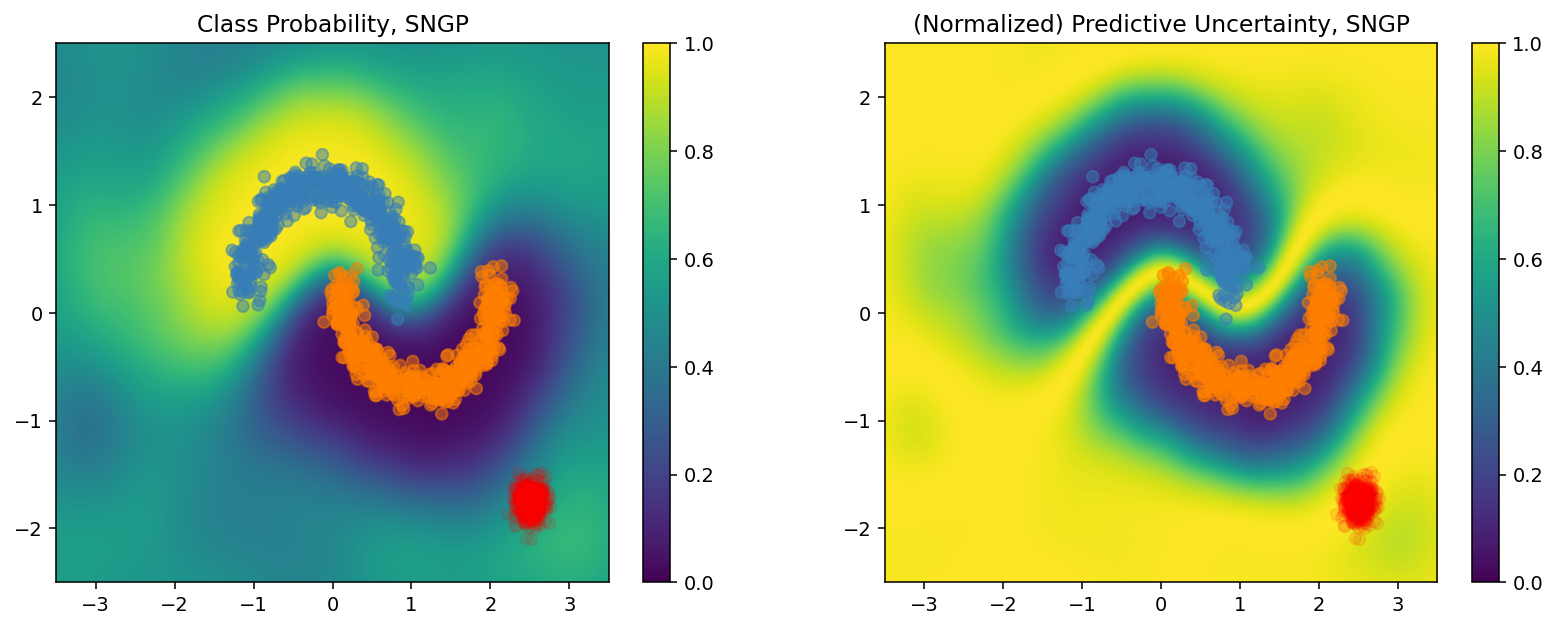

In [22]:
plot_predictions(prob, model_name="SNGP")